In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm

from pygam import (s as s_gam, l as l_gam, f as f_gam, LinearGAM, LogisticGAM)

from ISLP import load_data
from ISLP.models import (summarize, poly, ModelSpec as MS, bs, ns)
from ISLP.transforms import (BSpline, NaturalSpline)
from ISLP.pygam import (approx_lam, degrees_of_freedom, plot as plot_gam, anova as anova_gam)

precision=2
# np.set_printoptions(precision=precision)
# pd.set_option('display.precision', precision)
# pd.set_option('styler.format.thousands', '{:,}')
pd.reset_option('display.precision')

## Polynomial regression and step functions

In [2]:
Wage = load_data('Wage')
y = Wage.loc[:, 'wage']
age = Wage.loc[:, 'age']
y.shape, age.shape

((3000,), (3000,))

In [3]:
age.head()

0    18
1    24
2    45
3    43
4    50
Name: age, dtype: int64

In [4]:
df = pd.DataFrame({'x': np.array([1, 2, 3, 4])})
df.head()

,x
0,1
1,2
2,3
3,4


In [5]:
MS([poly('x', degree=3)]).fit_transform(df)

,intercept,"poly(x, degree=3)[0]","poly(x, degree=3)[1]","poly(x, degree=3)[2]"
0,1.0,-0.670820,0.5,-0.223607
1,1.0,-0.223607,-0.5,0.670820
2,1.0,0.223607,-0.5,-0.670820
3,1.0,0.670820,0.5,0.223607


In [6]:
# How the the polynomial features are computed? they look weird
poly_age = MS([poly('age', degree=4)]).fit(Wage)
poly_age.transform(Wage)

,intercept,"poly(age, degree=4)[0]","poly(age, degree=4)[1]","poly(age, degree=4)[2]","poly(age, degree=4)[3]"
0,1.0,-0.038625,0.055909,-0.071741,0.086730
1,1.0,-0.029133,0.026298,-0.014550,-0.002599
2,1.0,0.004090,-0.014507,-0.000133,0.014480
3,1.0,0.000926,-0.014831,0.004514,0.012658
4,1.0,0.012000,-0.009816,-0.011137,0.010211
...,...,...,...,...,...
2995,1.0,0.002508,-0.014780,0.002213,0.013811
2996,1.0,-0.019640,0.004666,0.011745,-0.019385
2997,1.0,-0.024387,0.014485,0.001911,-0.017160
2998,1.0,-0.024387,0.014485,0.001911,-0.017160


In [7]:
M = sm.OLS(y, poly_age.transform(Wage)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


In [8]:
# evenly spaced age
age_grid = np.linspace(age.min(), age.max(), 100)
age_df = pd.DataFrame({'age': age_grid})
age_df

,age
0,18.000000
1,18.626263
2,19.252525
3,19.878788
4,20.505051
...,...
95,77.494949
96,78.121212
97,78.747475
98,79.373737


In [9]:
def plot_wage_fit(age_df, basis, title, fontsize=16):
    X = basis.transform(Wage)
    Xnew = basis.transform(age_df)
    M = sm.OLS(y, X).fit()
    preds = M.get_prediction(Xnew)
    bands = preds.conf_int(alpha=0.05)
    _, ax = plt.subplots()
    ax.scatter(
        age, y,
        facecolor='gray',
        alpha=0.2
    )
    for val, ls in zip([preds.predicted_mean,
        bands[:,0], bands[:,1]],['b','r--','r--']):
        ax.plot(age_df.values, val, ls, linewidth=3)
    ax.set_title(title, fontsize=fontsize)
    ax.set_xlabel('Age', fontsize=fontsize)
    ax.set_ylabel('Wage', fontsize=fontsize);
    return ax

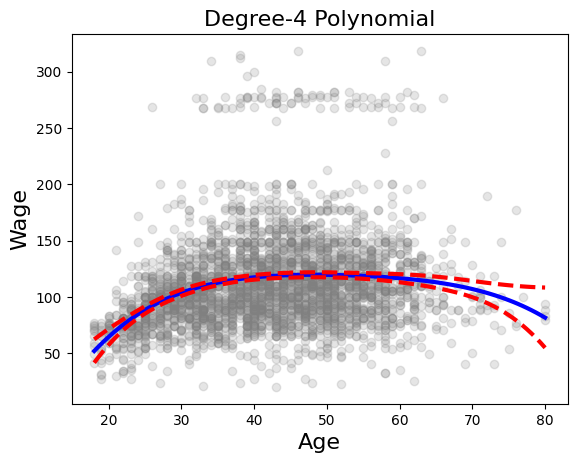

In [10]:
plot_wage_fit(age_df, poly_age, 'Degree-4 Polynomial');

In [11]:
models = [MS([poly('age', degree=d)]) for d in range(1, 6)]
Xs = [model.fit_transform(Wage) for model in models]
anova_lm(*[sm.OLS(y, X_).fit() for X_ in Xs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


In [12]:
def myfunc(a, b, c):
    return a, b, c

In [13]:
myfunc(*[1, 2, 3])

(1, 2, 3)

In [14]:
models = [MS(['education', poly('age', degree=d)])
          for d in range(1, 4)]
XEs = [model.fit_transform(Wage)
       for model in models]
anova_lm(*[sm.OLS(y, X_).fit() for X_ in XEs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2997.0,3.902335e+06,0.0,NaN,NaN,NaN
1,2996.0,3.759472e+06,1.0,142862.701185,113.991883,3.838075e-26
2,2995.0,3.753546e+06,1.0,5926.207070,4.728593,2.974318e-02


In [15]:
X = poly_age.transform(Wage)
high_earn = Wage['high_earn'] = y > 250
glm = sm.GLM(y > 250, X, family=sm.families.Binomial())
B = glm.fit()
summarize(B)

,coef,std err,z,P>|z|
intercept,-4.3012,0.345,-12.457,0.000
"poly(age, degree=4)[0]",71.9642,26.133,2.754,0.006
"poly(age, degree=4)[1]",-85.7729,35.929,-2.387,0.017
"poly(age, degree=4)[2]",34.1626,19.697,1.734,0.083
"poly(age, degree=4)[3]",-47.4008,24.105,-1.966,0.049


In [16]:
newX = poly_age.transform(age_df)
preds = B.get_prediction(newX)
bands = preds.conf_int(alpha=0.05)

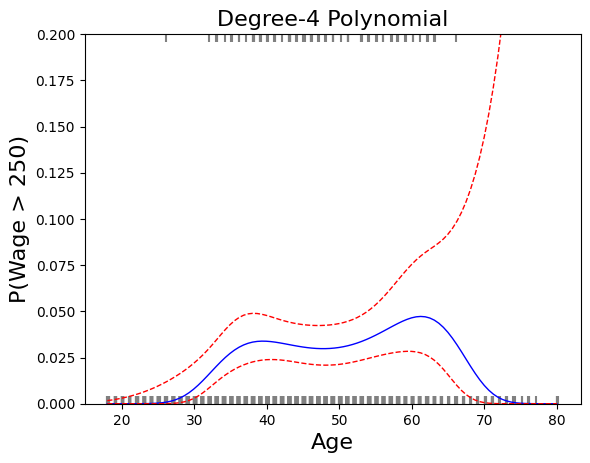

In [17]:
_, ax = plt.subplots()
rng = np.random.default_rng(0)
ax.scatter(age +
           0.2 * rng.uniform(size=y.shape[0]), # noise term
           np.where(high_earn, 0.198, 0.002),
           fc='gray',
           marker='|')
for val, ls in zip([preds.predicted_mean,
                  bands[:,0],
                  bands[:,1]],
                 ['b','r--','r--']):
    ax.plot(age_df.values, val, ls, linewidth=1)
ax.set_title('Degree-4 Polynomial', fontsize=16)
ax.set_xlabel('Age', fontsize=16)
ax.set_ylim([0,0.2])
ax.set_ylabel('P(Wage > 250)', fontsize=16);

In [18]:
cut_age = pd.qcut(age, 4)
cut_age

0       (17.999, 33.75]
1       (17.999, 33.75]
2          (42.0, 51.0]
3          (42.0, 51.0]
4          (42.0, 51.0]
             ...       
2995       (42.0, 51.0]
2996    (17.999, 33.75]
2997    (17.999, 33.75]
2998    (17.999, 33.75]
2999       (51.0, 80.0]
Name: age, Length: 3000, dtype: category
Categories (4, interval[float64, right]): [(17.999, 33.75] < (33.75, 42.0] < (42.0, 51.0] < (51.0, 80.0]]

In [19]:
Xage_cut = pd.get_dummies(cut_age)
Xage_cut

,"(17.999, 33.75]","(33.75, 42.0]","(42.0, 51.0]","(51.0, 80.0]"
0,True,False,False,False
1,True,False,False,False
2,False,False,True,False
3,False,False,True,False
4,False,False,True,False
...,...,...,...,...
2995,False,False,True,False
2996,True,False,False,False
2997,True,False,False,False
2998,True,False,False,False


In [20]:
summarize(sm.OLS(y, Xage_cut).fit())

,coef,std err,t,P>|t|
"(17.999, 33.75]",94.1584,1.478,63.692,0.0
"(33.75, 42.0]",116.6608,1.470,79.385,0.0
"(42.0, 51.0]",119.1887,1.416,84.147,0.0
"(51.0, 80.0]",116.5717,1.559,74.751,0.0


## Splines

In [21]:
bs_ = BSpline(internal_knots=[25, 40, 60], intercept=True).fit(age)
bs_age = bs_.transform(age)
bs_age.shape

(3000, 7)

In [22]:
bs_age.head()

,"BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0,\n upper_bound=80.0)[0]","BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0,\n upper_bound=80.0)[1]","BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0,\n upper_bound=80.0)[2]","BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0,\n upper_bound=80.0)[3]","BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0,\n upper_bound=80.0)[4]","BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0,\n upper_bound=80.0)[5]","BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0,\n upper_bound=80.0)[6]"
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.002915,0.559911,0.403778,0.033395,0.000000,0.000000,0.0
2,0.000000,0.000000,0.114796,0.618564,0.262733,0.003906,0.0
3,0.000000,0.000000,0.167109,0.633167,0.198880,0.000844,0.0
4,0.000000,0.000000,0.034014,0.508194,0.426542,0.031250,0.0


In [23]:
bs_age = MS([bs('age', internal_knots=[25, 40, 60])])
Xbs = bs_age.fit_transform(Wage)
M = sm.OLS(y, Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,60.4937,9.460,6.394,0.000
"bs(age, internal_knots=[25, 40, 60])[0]",3.9805,12.538,0.317,0.751
"bs(age, internal_knots=[25, 40, 60])[1]",44.6310,9.626,4.636,0.000
"bs(age, internal_knots=[25, 40, 60])[2]",62.8388,10.755,5.843,0.000
"bs(age, internal_knots=[25, 40, 60])[3]",55.9908,10.706,5.230,0.000
"bs(age, internal_knots=[25, 40, 60])[4]",50.6881,14.402,3.520,0.000
"bs(age, internal_knots=[25, 40, 60])[5]",16.6061,19.126,0.868,0.385


In [24]:
bs_age = MS([bs('age', internal_knots=[25, 40, 60], name='bs(age)')])
Xbs = bs_age.fit_transform(Wage)
M = sm.OLS(y, Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,60.4937,9.460,6.394,0.000
bs(age)[0],3.9805,12.538,0.317,0.751
bs(age)[1],44.6310,9.626,4.636,0.000
bs(age)[2],62.8388,10.755,5.843,0.000
bs(age)[3],55.9908,10.706,5.230,0.000
bs(age)[4],50.6881,14.402,3.520,0.000
bs(age)[5],16.6061,19.126,0.868,0.385


In [25]:
BSpline(df=6).fit(age).internal_knots_

array([33.75, 42.  , 51.  ])

In [26]:
bs_age0 = MS([bs('age', df=3, degree=0)]).fit(Wage)
Xbs0 = bs_age0.transform(Wage)
summarize(sm.OLS(y, Xbs0).fit())

,coef,std err,t,P>|t|
intercept,94.1584,1.478,63.687,0.0
"bs(age, df=3, degree=0)[0]",22.3490,2.152,10.388,0.0
"bs(age, df=3, degree=0)[1]",24.8076,2.044,12.137,0.0
"bs(age, df=3, degree=0)[2]",22.7814,2.087,10.917,0.0


In [27]:
ns_age = MS([ns('age', df=5)]).fit(Wage)
M_ns = sm.OLS(y, ns_age.transform(Wage)).fit()
summarize(M_ns)

,coef,std err,t,P>|t|
intercept,60.4752,4.708,12.844,0.000
"ns(age, df=5)[0]",61.5267,4.709,13.065,0.000
"ns(age, df=5)[1]",55.6912,5.717,9.741,0.000
"ns(age, df=5)[2]",46.8184,4.948,9.463,0.000
"ns(age, df=5)[3]",83.2036,11.918,6.982,0.000
"ns(age, df=5)[4]",6.8770,9.484,0.725,0.468


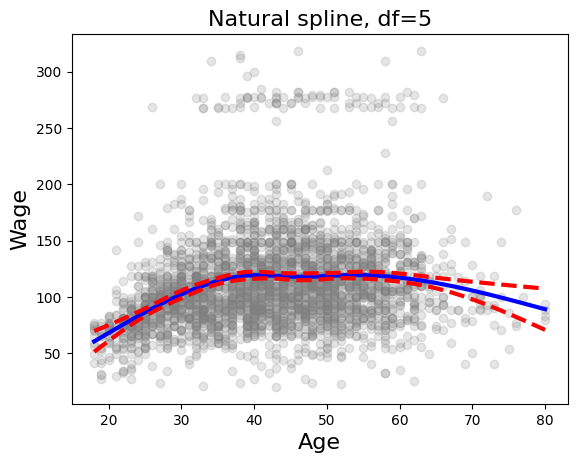

In [28]:
plot_wage_fit(age_df, ns_age, 'Natural spline, df=5');

## Smoothing splines and GAMs

In [29]:
X_age = np.asarray(age).reshape((-1, 1))
X_age

array([[18],
       [24],
       [45],
       ...,
       [27],
       [27],
       [55]])

In [30]:
gam = LinearGAM(s_gam(0, lam=.6))
gam.fit(X_age, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False)

Below is an example of `np.reshape((-1, 1))`

In [31]:
z = np.arange(1, 13).reshape((3,4))
z

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12]])

In [32]:
z.shape

(3, 4)

In [33]:
z.reshape(-1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [34]:
z.reshape(-1,1)

array([[ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12]])

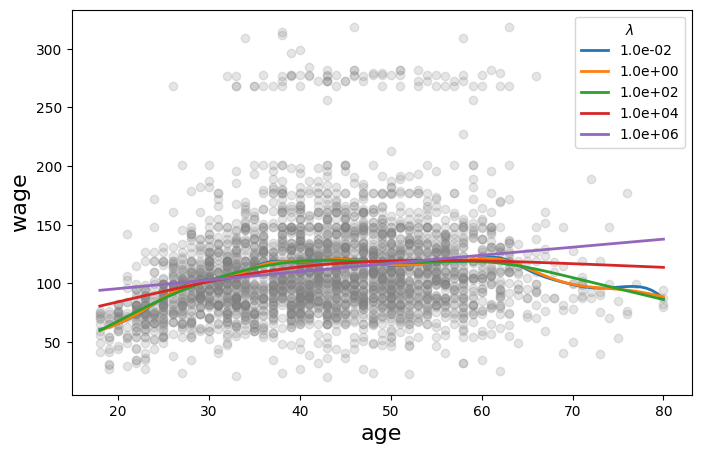

In [35]:
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(age, y, facecolor='gray', alpha=.2)

for lam in np.logspace(-2, 6, 5):
    gam = LinearGAM(s_gam(0, lam=lam)).fit(X_age, y)
    ax.plot(
        age_grid, 
        gam.predict(age_grid), 
        label='{:.1e}'.format(lam),
        linewidth=2
    )

ax.set_xlabel('age', fontsize=16)
ax.set_ylabel('wage', fontsize=16)
ax.legend(title='$\\lambda$');

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00


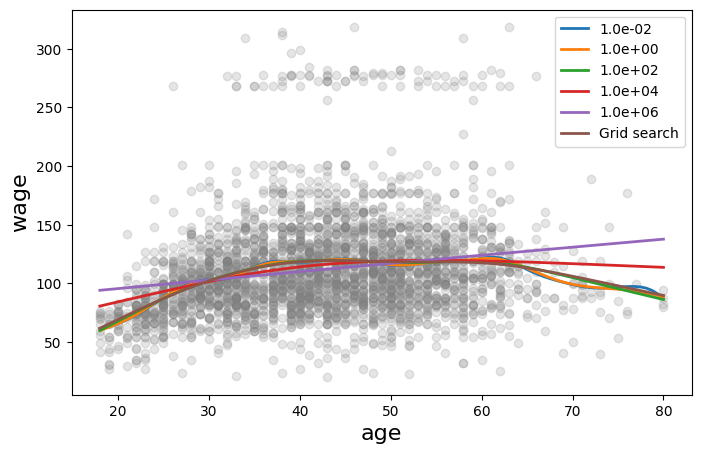

In [36]:
gam_opt = gam.gridsearch(X_age, y)
ax.plot(
    age_grid,
    gam_opt.predict(age_grid),
    label='Grid search',
    linewidth=2
)
ax.legend()
fig

In [37]:
age_term = gam.terms[0]
lam_4 = approx_lam(X_age, age_term, 4)
age_term.lam = lam_4
degrees_of_freedom(X_age, age_term)

4.000000100001664

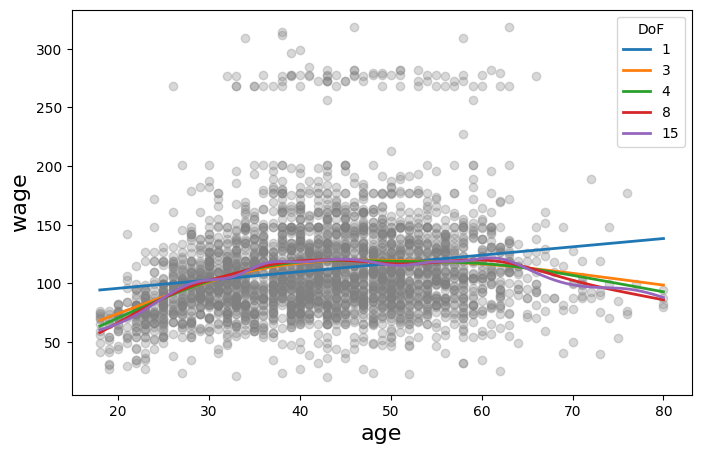

In [38]:
_, ax = plt.subplots(figsize=(8, 5))
ax.scatter(X_age, y, facecolor='gray', alpha=.3)

for df in [1, 3, 4, 8, 15]:
    lam = approx_lam(X_age, age_term, df+1)
    age_term.lam = lam
    gam.fit(X_age, y)
    ax.plot(
        age_grid, 
        gam.predict(age_grid),
        label='{:d}'.format(df),
        linewidth=2,
    )

ax.set_xlabel('age', fontsize=16)
ax.set_ylabel('wage', fontsize=16)
ax.legend(title='DoF');

### Additive models with several terms

In [39]:
ns_age = NaturalSpline(df=4).fit(age)
ns_age

,intercept,False
,lower_bound,None
,upper_bound,None
,internal_knots,None
,df,4
,ext,0


In [40]:
ns_year = NaturalSpline(df=5).fit(Wage['year'])
ns_year

,intercept,False
,lower_bound,None
,upper_bound,None
,internal_knots,None
,df,5
,ext,0


In [41]:
Xs = [
    ns_age.transform(age),
    ns_year.transform(Wage['year']),
    pd.get_dummies(Wage['education']).values
]
# wtf is bh?
X_bh = np.hstack(Xs)
gam_bh = sm.OLS(y, X_bh).fit()
summarize(gam_bh)

,coef,std err,t,P>|t|
x1,46.4460,3.732,12.446,0.000
x2,28.9349,3.884,7.449,0.000
x3,63.6722,9.231,6.898,0.000
x4,10.9669,7.650,1.434,0.152
x5,1.8374,3.177,0.578,0.563
x6,10.4409,3.790,2.755,0.006
x7,2.0020,3.399,0.589,0.556
x8,9.6055,4.053,2.370,0.018
x9,5.8989,2.419,2.438,0.015
x10,43.8013,4.383,9.993,0.000


In [42]:
age_grid = np.linspace(age.min(), age.max(), 100)
age_grid

array([18.        , 18.62626263, 19.25252525, 19.87878788, 20.50505051,
       21.13131313, 21.75757576, 22.38383838, 23.01010101, 23.63636364,
       24.26262626, 24.88888889, 25.51515152, 26.14141414, 26.76767677,
       27.39393939, 28.02020202, 28.64646465, 29.27272727, 29.8989899 ,
       30.52525253, 31.15151515, 31.77777778, 32.4040404 , 33.03030303,
       33.65656566, 34.28282828, 34.90909091, 35.53535354, 36.16161616,
       36.78787879, 37.41414141, 38.04040404, 38.66666667, 39.29292929,
       39.91919192, 40.54545455, 41.17171717, 41.7979798 , 42.42424242,
       43.05050505, 43.67676768, 44.3030303 , 44.92929293, 45.55555556,
       46.18181818, 46.80808081, 47.43434343, 48.06060606, 48.68686869,
       49.31313131, 49.93939394, 50.56565657, 51.19191919, 51.81818182,
       52.44444444, 53.07070707, 53.6969697 , 54.32323232, 54.94949495,
       55.57575758, 56.2020202 , 56.82828283, 57.45454545, 58.08080808,
       58.70707071, 59.33333333, 59.95959596, 60.58585859, 61.21

In [43]:
X_age_bh = X_bh.copy()[:100]
X_age_bh

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.01731602, -0.13795411,  0.31872157, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.7510856 ,  0.16605047,  0.09131609, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 0.7510856 ,  0.16605047,  0.09131609, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.78017192,  0.07222489,  0.11002552, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.27056277, -0.20863018,  0.48200765, ...,  0.        ,
         1.        ,  0.        ]])

In [44]:
X_age_bh[:] = X_bh[:].mean(0)[np.newaxis, :]
X_age_bh

array([[0.41104614, 0.10758615, 0.25528707, ..., 0.21666667, 0.22833333,
        0.142     ],
       [0.41104614, 0.10758615, 0.25528707, ..., 0.21666667, 0.22833333,
        0.142     ],
       [0.41104614, 0.10758615, 0.25528707, ..., 0.21666667, 0.22833333,
        0.142     ],
       ...,
       [0.41104614, 0.10758615, 0.25528707, ..., 0.21666667, 0.22833333,
        0.142     ],
       [0.41104614, 0.10758615, 0.25528707, ..., 0.21666667, 0.22833333,
        0.142     ],
       [0.41104614, 0.10758615, 0.25528707, ..., 0.21666667, 0.22833333,
        0.142     ]])

In [45]:
X_age_bh[:, :4] = ns_age.transform(age_grid)
X_age_bh

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.16666667e-01,  2.28333333e-01,  1.42000000e-01],
       [ 1.96908174e-05, -1.54710200e-02,  3.57433910e-02, ...,
         2.16666667e-01,  2.28333333e-01,  1.42000000e-01],
       [ 1.57526539e-04, -3.08712095e-02,  7.13231391e-02, ...,
         2.16666667e-01,  2.28333333e-01,  1.42000000e-01],
       ...,
       [ 3.85537068e-05, -1.04498156e-01,  3.70847794e-01, ...,
         2.16666667e-01,  2.28333333e-01,  1.42000000e-01],
       [ 4.81921335e-06, -1.33566470e-01,  3.73351572e-01, ...,
         2.16666667e-01,  2.28333333e-01,  1.42000000e-01],
       [ 0.00000000e+00, -1.62680839e-01,  3.75848834e-01, ...,
         2.16666667e-01,  2.28333333e-01,  1.42000000e-01]])

In [46]:
preds = gam_bh.get_prediction(X_age_bh)
bounds_age = preds.conf_int(alpha=0.05)
partial_age = preds.predicted_mean
center = partial_age.mean()
partial_age -= center
bounds_age -= center

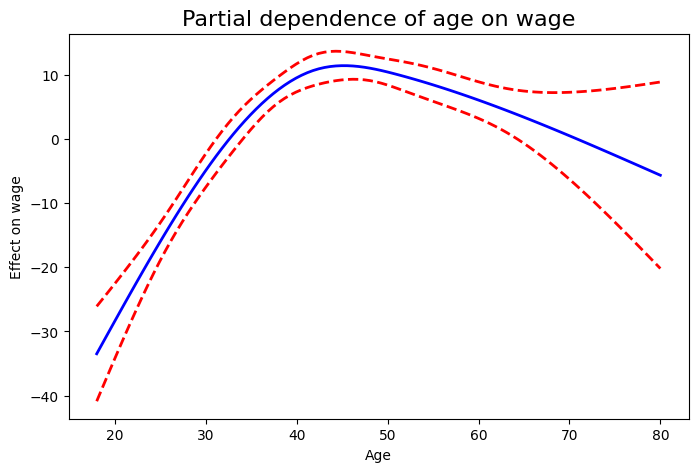

In [47]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(age_grid, partial_age, 'b', linewidth=2)
ax.plot(age_grid, bounds_age[:,0], 'r--', linewidth=2)
ax.plot(age_grid, bounds_age[:,1], 'r--', linewidth=2)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage', fontsize=16);

In [48]:
year_grid = np.linspace(2003, 2009, 100)
year_grid = np.linspace(Wage['year'].min(),
                        Wage['year'].max(),
                        100)
X_year_bh = X_bh.copy()[:100]
X_year_bh[:] = X_bh[:].mean(0)[None,:]
X_year_bh[:,4:9] = ns_year.transform(year_grid)
preds = gam_bh.get_prediction(X_year_bh)
bounds_year = preds.conf_int(alpha=.05)
partial_year = preds.predicted_mean
center = partial_year.mean()
partial_year -= center
bounds_year -= center

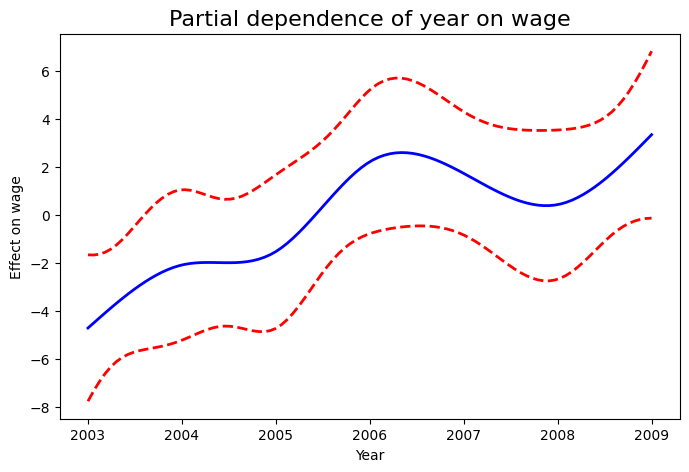

In [49]:
_, ax = plt.subplots(figsize=(8,5))
ax.plot(year_grid, partial_year, 'b', linewidth=2)
ax.plot(year_grid, bounds_year[:,0], 'r--', linewidth=2)
ax.plot(year_grid, bounds_year[:,1], 'r--', linewidth=2)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of year on wage', fontsize=16);

In [50]:
gam_full = LinearGAM(s_gam(0) +
                     s_gam(1, n_splines=7) +
                     f_gam(2, lam=0))
Xgam = np.column_stack([age,
                        Wage['year'],
                        Wage['education'].cat.codes])
gam_full = gam_full.fit(Xgam, y)

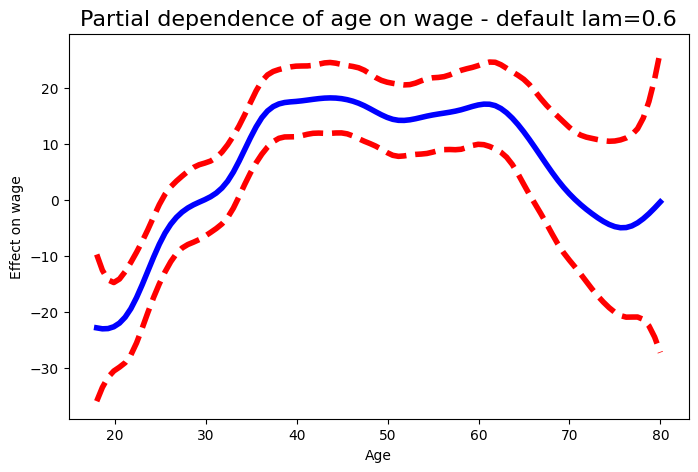

In [51]:
_, ax = plt.subplots(figsize=(8,5))
plot_gam(gam_full, 0, ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage - default lam=0.6', fontsize=16);

In [52]:
age_term = gam_full.terms[0]
age_term.lam = approx_lam(Xgam, age_term, df=4+1)
year_term = gam_full.terms[1]
year_term.lam = approx_lam(Xgam, year_term, df=4+1)
gam_full = gam_full.fit(Xgam, y)

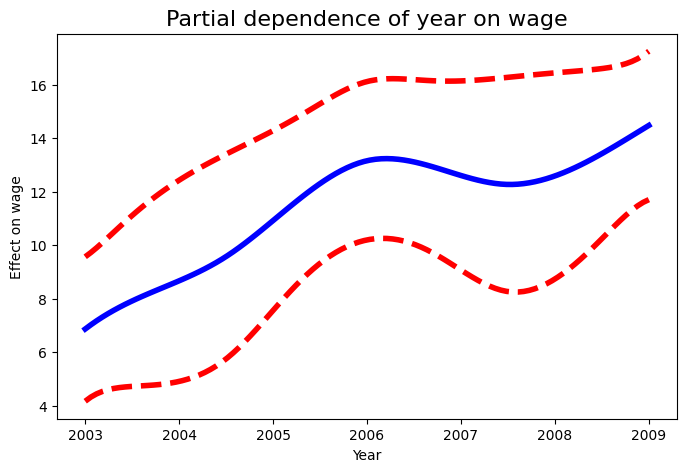

In [53]:
_, ax = plt.subplots(figsize=(8,5))

ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of year on wage', fontsize=16)

plot_gam(gam_full, 1, ax=ax);

/var/folders/cr/qs1xtj294pj5sj1y0055bt6m0000gn/T/ipykernel_5606/1391409514.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(Wage['education'].cat.categories, fontsize=8)


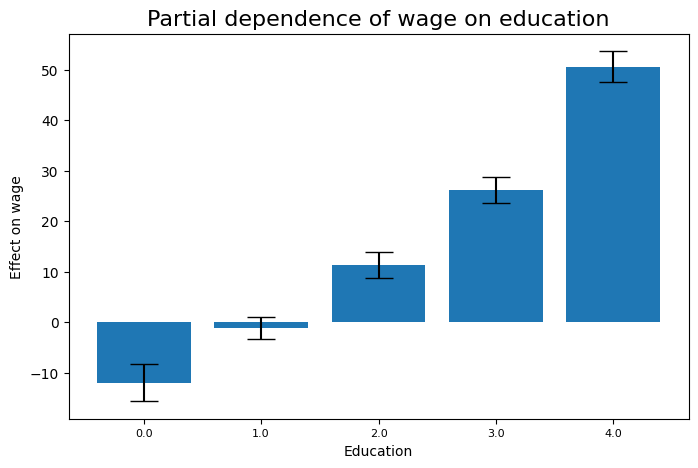

In [54]:
_, ax = plt.subplots(figsize=(8, 5))

ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on education',
             fontsize=16);
ax.set_xticklabels(Wage['education'].cat.categories, fontsize=8)

plot_gam(gam_full, 2, ax=ax);

### ANOVA test for additive models

In [55]:
gam_0 = LinearGAM(age_term + f_gam(2, lam=0))
gam_0.fit(Xgam, y)
gam_linear = LinearGAM(age_term +
                       l_gam(1, lam=0) +
                       f_gam(2, lam=0))
gam_linear.fit(Xgam, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + l(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

In [56]:
anova_gam(gam_0, gam_linear, gam_full)

,deviance,df,deviance_diff,df_diff,F,pvalue
0,3.714362e+06,2991.004005,NaN,NaN,NaN,NaN
1,3.696746e+06,2990.005190,17616.542840,0.998815,14.265131,0.002314
2,3.693143e+06,2987.007254,3602.893655,2.997936,0.972007,0.435579


In [57]:
gam_0 = LinearGAM(year_term +
                  f_gam(2, lam=0))
gam_linear = LinearGAM(l_gam(0, lam=0) +
                       year_term +
                       f_gam(2, lam=0))
gam_0.fit(Xgam, y)
gam_linear.fit(Xgam, y)
anova_gam(gam_0, gam_linear, gam_full)

,deviance,df,deviance_diff,df_diff,F,pvalue
0,3.975443e+06,2991.000589,NaN,NaN,NaN,NaN
1,3.850247e+06,2990.000704,125196.137317,0.999884,101.270106,1.681120e-07
2,3.693143e+06,2987.007254,157103.978302,2.993450,42.447812,5.669414e-07


In [58]:
gam_full.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     12.9927
Link Function:                     IdentityLink Log Likelihood:                                 -24117.907
Number of Samples:                         3000 AIC:                                            48263.7995
                                                AICc:                                             48263.94
                                                GCV:                                             1246.1129
                                                Scale:                                           1236.4024
                                                Pseudo R-Squared:                                   0.2928
Feature Function                  Lam

/var/folders/cr/qs1xtj294pj5sj1y0055bt6m0000gn/T/ipykernel_5606/3870570873.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_full.summary()


In [59]:
Y_hat = gam_full.predict(Xgam)
Y_hat

array([ 52.3662492 ,  99.63834745, 111.7723448 , ...,  70.20962308,
        93.60649596, 104.91135937])

In [60]:
gam_logit = LogisticGAM(age_term + 
                        l_gam(1, lam=0) +
                        f_gam(2, lam=0))
gam_logit.fit(Xgam, high_earn)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + l(1) + f(2) + intercept, tol=0.0001, verbose=False)

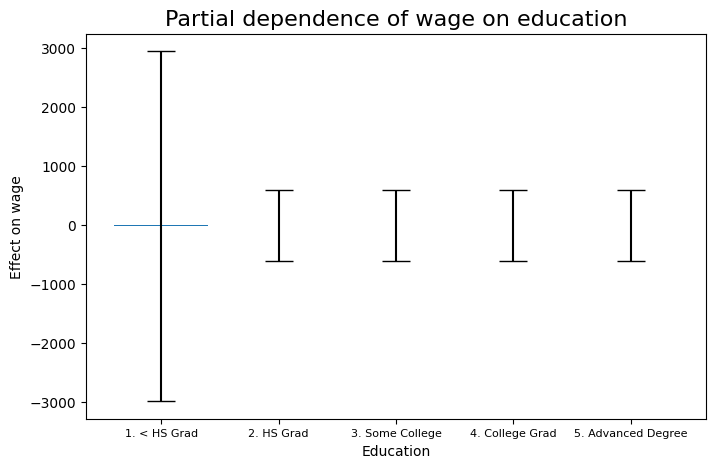

In [61]:
_, ax = plt.subplots(figsize=(8, 5))
ax = plot_gam(gam_logit, 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on education',
             fontsize=16);
ax.set_xticklabels(Wage['education'].cat.categories, fontsize=8);

In [62]:
pd.crosstab(Wage['high_earn'], Wage['education'])

education,1. < HS Grad,2. HS Grad,3. Some College,4. College Grad,5. Advanced Degree
high_earn,,,,,
False,268,966,643,663,381
True,0,5,7,22,45


In [63]:
only_hs = Wage['education'] == '1. < HS Grad'
Wage_ = Wage.loc[~only_hs]
Xgam_ = np.column_stack([Wage_['age'],
                         Wage_['year'],
                         Wage_['education'].cat.codes-1])
high_earn_ = Wage_['high_earn']

In [64]:
gam_logit_ = LogisticGAM(age_term +
                         year_term +
                         f_gam(2, lam=0))
gam_logit_.fit(Xgam_, high_earn_)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + f(2) + intercept, tol=0.0001, verbose=False)

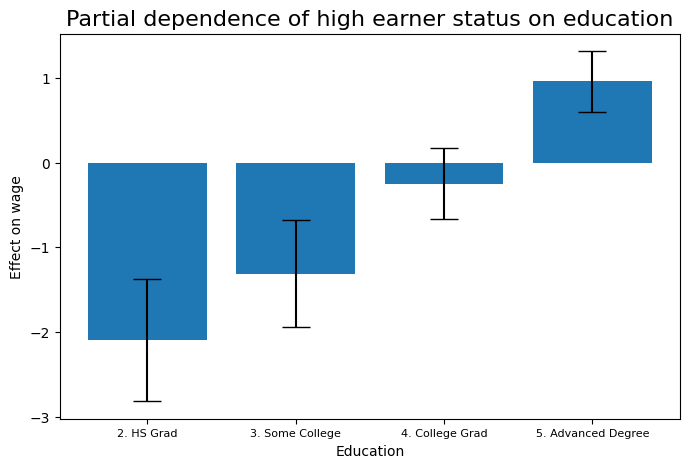

In [65]:
_, ax = plt.subplots(figsize=(8, 5))
ax = plot_gam(gam_logit_, 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of high earner status on education', fontsize=16);
ax.set_xticklabels(Wage['education'].cat.categories[1:],
                   fontsize=8);

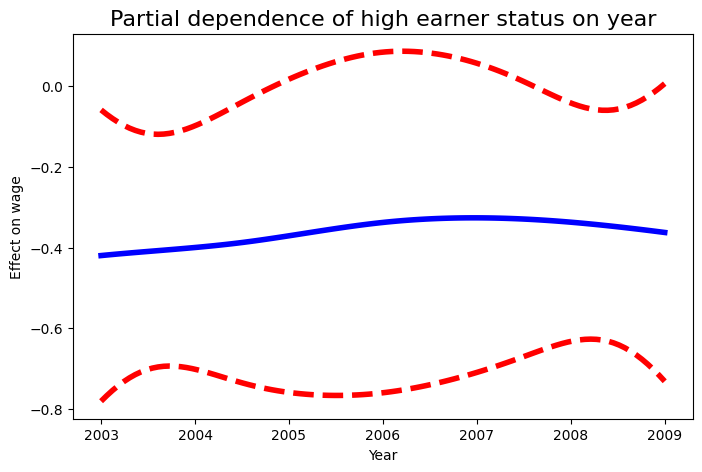

In [66]:
_, ax = plt.subplots(figsize=(8, 5))
ax = plot_gam(gam_logit_, 1)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of high earner status on year', fontsize=16);

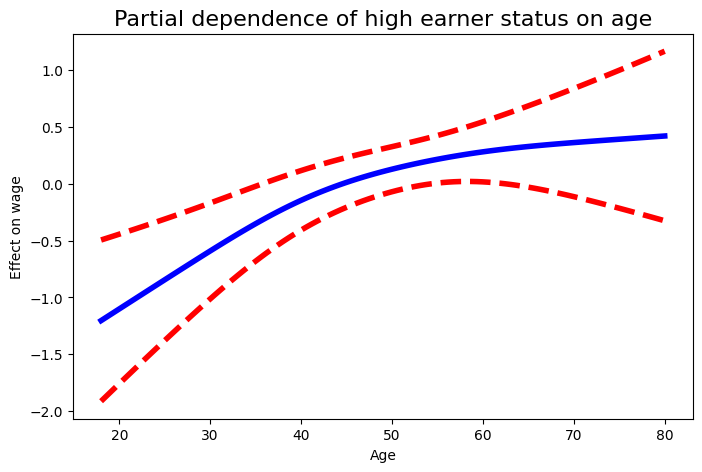

In [67]:
fig, ax = plt.subplots(figsize=(8, 5))
ax = plot_gam(gam_logit_, 0)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of high earner status on age', fontsize=16);

## Local regression

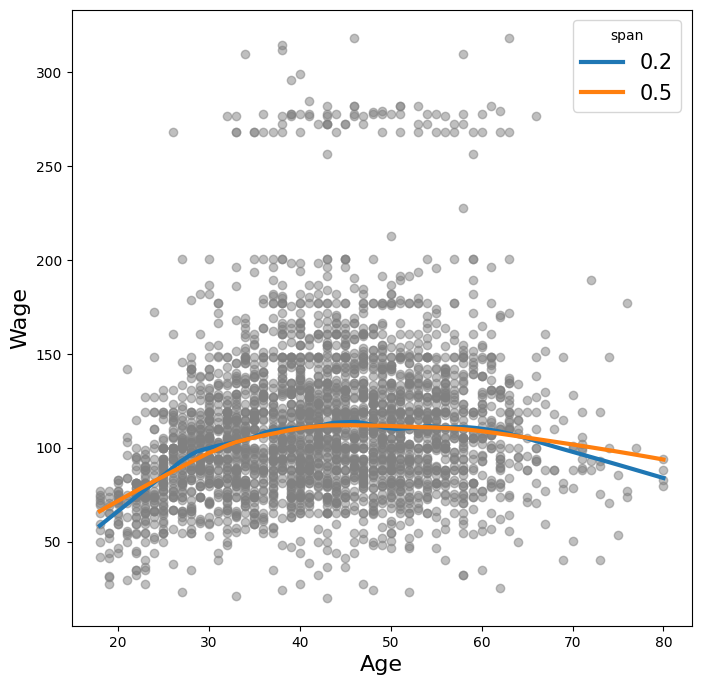

In [68]:
lowess = sm.nonparametric.lowess
_, ax = plt.subplots(figsize=(8,8))
ax.scatter(age, y, facecolor='gray', alpha=0.5)
for span in [0.2, 0.5]:
    fitted = lowess(y, age, frac=span, xvals=age_grid)
    ax.plot(age_grid,
            fitted,
            label='{:.1f}'.format(span),
            linewidth=3)
ax.set_xlabel('Age', fontsize=16)
ax.set_ylabel('Wage', fontsize=16)
ax.legend(title='span', fontsize=15);